# Run this

In [11]:
import numpy as np
import scipy.optimize as opt
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display, clear_output

In [12]:
# Define the linear model for fitting
def linear_model(T, c, m):
    return c + m * T

# Function to calculate uncertainty
def uncertainty_line(x, popt, pcov):
    return 2.45 * np.sqrt(pcov[0, 0] + x**2 * pcov[1, 1] + 2 * x * pcov[0, 1])

def round_to_sig_figs(x_array, y, sig_figs=2):
    if y == 0:
        return x_array, 0  # If y is 0, return x_array unchanged and y as 0

    # Step 1: Calculate the exponent (order of magnitude) of y
    exponent = int(np.floor(np.log10(abs(y))))

    # Step 2: Scale y using the same scale factor based on y's exponent
    scale_factor = 10 ** (sig_figs - 1 - exponent)

    # Now round each element in x_array with the same significance
    rounded_x_array = []
    for x in x_array:
        scaled_value_x = x * scale_factor
        rounded_scaled_value_x = round(scaled_value_x)
        rounded_value_x = rounded_scaled_value_x / scale_factor
        rounded_value_x = int(rounded_value_x) if rounded_value_x.is_integer() else rounded_value_x
        rounded_x_array.append(rounded_value_x)

    return np.array(rounded_x_array)

# Define the Monte Carlo simulation and plotting function
def monte_carlo_linear_fit(x_data, y_data, x_uncertainty, y_uncertainty, x_axis_label, y_axis_label, x_axis_unit, y_axis_unit, graph_title):
    intercept = []
    slope = []
    num_simulations = 10000

    for i in range(num_simulations):
        MC_y_data = np.random.normal(loc=y_data, scale=y_uncertainty)
        MC_x_data = np.random.normal(loc=x_data, scale=x_uncertainty)

        popt, _ = opt.curve_fit(linear_model, MC_x_data, MC_y_data)
        intercept.append(popt[0])
        slope.append(popt[1])

    popt_monteCarlo = np.array([np.mean(intercept), np.mean(slope)])
    pcov_monteCarlo = np.cov(intercept, slope)

    xvals = np.linspace( 1.1 * min(x_data) - 0.1 * max(x_data) , 1.1 * max(x_data) - 0.1 * min(x_data) , 100 )
    yvals = linear_model(xvals, popt_monteCarlo[0], popt_monteCarlo[1])

    #calculate the worst fit lines
    y1vals = linear_model(xvals, popt_monteCarlo[0] + 2.45 * np.sqrt(pcov_monteCarlo[0, 0]), popt_monteCarlo[1] - 2.45 * np.sqrt(pcov_monteCarlo[1, 1]))
    y2vals = linear_model(xvals, popt_monteCarlo[0] - 2.45 * np.sqrt(pcov_monteCarlo[0, 0]), popt_monteCarlo[1] + 2.45 * np.sqrt(pcov_monteCarlo[1, 1]))

    # Calculate the uncertainty for each x-value
    uncertainties = uncertainty_line(xvals, popt_monteCarlo, pcov_monteCarlo)

    # Calculate the upper and lower bounds
    y_upper = yvals + uncertainties
    y_lower = yvals - uncertainties

    labels_slope = round_to_sig_figs(np.array([
        popt_monteCarlo[1],
        popt_monteCarlo[1] - 2.45 * np.sqrt(pcov_monteCarlo[1, 1]),
        popt_monteCarlo[1] + 2.45 * np.sqrt(pcov_monteCarlo[1, 1])
    ]),2.45 * np.sqrt(pcov_monteCarlo[1, 1]),2)
    labels_int = round_to_sig_figs(np.array([
        popt_monteCarlo[0],
        popt_monteCarlo[0] - 2.45 * np.sqrt(pcov_monteCarlo[0, 0]),
        popt_monteCarlo[0] + 2.45 * np.sqrt(pcov_monteCarlo[0,0])
    ]),2.45 * np.sqrt(pcov_monteCarlo[1, 1]),2)

    plt.figure(figsize=(8, 6))

    plt.errorbar(x_data, y_data, xerr=x_uncertainty, yerr=y_uncertainty, fmt='o', capsize=3, label='Measured data')
    plt.plot(xvals, yvals, color='g', linewidth=4, label=f'y = {labels_slope[0]}x {"-" if labels_int[0] < 0 else "+"} {abs(labels_int[0])}')
    plt.plot(xvals, y1vals, color='r', linewidth=1, linestyle='--', label=f'95% CI lower: y = {labels_slope[1]}x {"-" if labels_int[2] < 0 else "+"} {abs(labels_int[2])}')
    plt.plot(xvals, y2vals, color='r', linewidth=1, linestyle='--', label=f'95% CI upper: y = {labels_slope[2]}x {"-" if labels_int[1] < 0 else "+"} {abs(labels_int[1])}')
    plt.fill_between(xvals, y_lower, y_upper, where=(y_upper > y_lower), color='lightblue', alpha=0.5, interpolate=True, label='95% Confidence Region')

    plt.xlabel(f'{x_axis_label} [{x_axis_unit}]')
    plt.ylabel(f'{y_axis_label} [{y_axis_unit}]')
    plt.title(graph_title)
    plt.legend()
    clear_output()
    plt.show()


# Function to handle the button click
def on_submit_button_clicked(b):
    clear_output()  # Clear previous processing messages
    print("Calculating... This might take a few seconds")  # Show processing messagewith processing_output:


    # Retrieve input values
    input_values = {
        "graph_title": graph_title.value,
        "x_axis_title": x_axis_title.value,
        "x_axis_unit": x_axis_unit.value,
        "y_axis_title": y_axis_title.value,
        "y_axis_unit": y_axis_unit.value,
        "data": data_input.value.strip()
    }

    # Process the data (convert it to numpy arrays for each component)
    data = np.array([list(map(float, row.split())) for row in input_values['data'].splitlines()])

    # Extract y-data, y-uncertainty, x-data, and x-uncertainty
    y_data = data[:, 0]  # First column is y-data
    y_uncertainty = data[:, 1]  # Second column is uncertainty in y-data
    x_data = data[:, 2]  # Third column is x-data
    x_uncertainty = data[:, 3]  # Fourth column is uncertainty in x-data

    # Call the Monte Carlo linear fit function (simulated here)
    monte_carlo_linear_fit(
        x_data,
        y_data,
        x_uncertainty,
        y_uncertainty,
        input_values['x_axis_title'],
        input_values['y_axis_title'],
        input_values['x_axis_unit'],
        input_values['y_axis_unit'],
        input_values['graph_title']
    )


# New Section

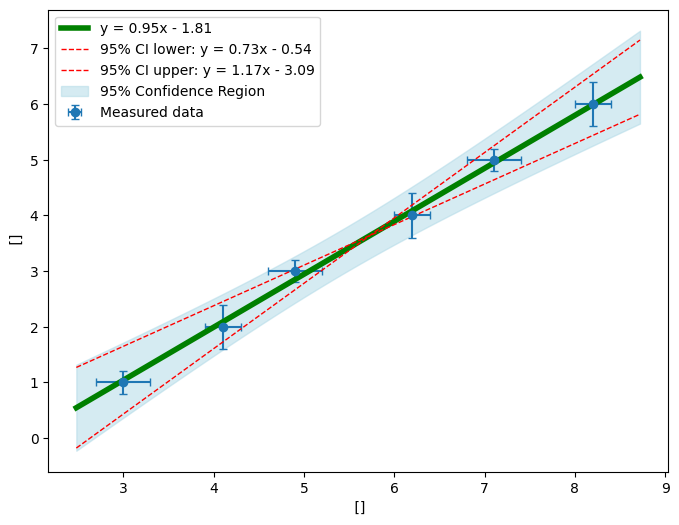

In [15]:
# Create input fields for the graph title, axis titles, and axis units
graph_title = widgets.Text(value='', placeholder='Enter graph title', description='Graph Title:')
x_axis_title = widgets.Text(value='', placeholder='Enter x-axis title', description='X-axis Title:')
x_axis_unit = widgets.Text(value='', placeholder='Enter x-axis unit', description='X-axis Unit:')
y_axis_title = widgets.Text(value='', placeholder='Enter y-axis title', description='Y-axis Title:')
y_axis_unit = widgets.Text(value='', placeholder='Enter y-axis unit', description='Y-axis Unit:')

# Create a TextArea widget for data input
data_input = widgets.Textarea(
    value='',
    placeholder=(
        'Paste your data here: y-data, y-uncertainty, x-data, x-uncertainty (one row per datapoint).'
    ),
    description='Data Input:',
    layout=widgets.Layout(width='500px', height='150px')
)


# Create a submit button
submit_button = widgets.Button(description="Submit")

# Link the button click to the function
submit_button.on_click(on_submit_button_clicked)

# Display the widgets
display(graph_title, x_axis_title, x_axis_unit, y_axis_title, y_axis_unit, data_input, submit_button)

